# Census Data
## Intro to GIS Analysis

Since weather data is highly location dependent, we need to look at specific sites for accessing weather data. So far, we've focused on ISONE and New Hampshire, so let's continue with that trend.

This notebook drew inspiration from a [tutorial on `PyGIS` website](https://pygis.io/docs/d_access_census.html) by Steven Chao.

First, we'll download some "shapefiles" and population data from the US Census, then we'll access weather data from NWS.

In [1]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from dotenv import load_dotenv
import requests
import json
import os
import datetime as dt
from tqdm import trange, tqdm
from census import Census
from us import states
from shapely.geometry import Polygon, Point

pd.options.display.max_columns = None

# load the environment variables
load_dotenv()

# set api key
census_key = os.environ.get('CENSUS_API_KEY')

## Download census data

In [2]:
new_hampshire = states.lookup('NH')
nh_fips = new_hampshire.fips

In [3]:
c = Census(census_key)

In [4]:
nh_df = pd.DataFrame(c.acs5.state_county_tract(fields=('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                          state_fips=nh_fips, 
                          county_fips='*',
                          tract='*',
                          year=2021)
                     )
nh_df.head(3)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract
0,"Census Tract 9651, Belknap County, New Hampshire",3397.0,126.0,103.0,3397.0,33,001,965100
1,"Census Tract 9652, Belknap County, New Hampshire",3324.0,272.0,221.0,3324.0,33,001,965200
2,"Census Tract 9653, Belknap County, New Hampshire",3298.0,78.0,132.0,3306.0,33,001,965300


## Download shapefile data

For this, I created a function to automatically download a shapefile for any state.

In [5]:
_TIGER_URL = "https://www2.census.gov/geo/tiger/"

def get_tiger_files(year, state_abbr, feature='tract'):
    """
    This function retrievs a TIGER shapefile from the United States Census
    website.

    Parameters
    ----------
    year : int
        The shapefile year of interest.
    state_abbr : str
        The abbreviation for the state of interest.
    feature : str, optional
        Indicates which TIGER file data feature to extract, by default 'tract'.
    """
    
    
    try:
        state = states.lookup(state_abbr)
        assert state, f"{state_abbr} is not a state in the U.S."
    except AssertionError as error:
        raise error

    _FEATURE_FILE = {'tract':f'TRACT/tl_{year}_{state.fips}_tract.zip',
                     'county':f"COUNTY/tl_{year}_us_county.zip"}
    data_route = f"TIGER{year}/{_FEATURE_FILE[feature]}"
    
    geo_df = gpd.read_file(_TIGER_URL+data_route)
    
    return geo_df

In [6]:
nh_tracts = get_tiger_files(2022, 'NH')
nh_tracts.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,33,001,965802,33001965802,9658.02,Census Tract 9658.02,G5020,S,42284243,499214,+43.4554725,-071.4514896,"POLYGON ((-71.53589 43.44579, -71.53160 43.445..."
1,33,011,019501,33011019501,195.01,Census Tract 195.01,G5020,S,78829083,300378,+42.8964089,-071.7683309,"POLYGON ((-71.85505 42.89050, -71.83436 42.892..."
2,33,011,018502,33011018502,185.02,Census Tract 185.02,G5020,S,61990098,143147,+42.7421807,-071.7509684,"POLYGON ((-71.80816 42.72543, -71.80434 42.725..."


In [7]:
nh_tracts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

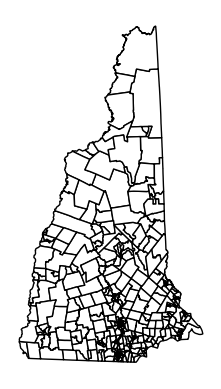

In [8]:
ax = nh_tracts.plot(facecolor='w',edgecolor='k')
ax.set_axis_off()

## Combine the datasets

The census dataset is missing geometry and has slightly different column information. With a few operations, we can merge these two datasets.

In [9]:
nh_df['GEOID'] = nh_df['state'] + nh_df['county'] + nh_df['tract']
nh_df.drop(columns=['state','county','tract'], inplace=True)
nh_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 9651, Belknap County, New Hampshire",3397.0,126.0,103.0,3397.0,33001965100
1,"Census Tract 9652, Belknap County, New Hampshire",3324.0,272.0,221.0,3324.0,33001965200


In [10]:
nh_combined = pd.merge(nh_tracts, nh_df, on='GEOID')
nh_combined.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,C17002_001E,C17002_002E,C17002_003E,B01003_001E
0,33,001,965802,33001965802,9658.02,Census Tract 9658.02,G5020,S,42284243,499214,+43.4554725,-071.4514896,"POLYGON ((-71.53589 43.44579, -71.53160 43.445...","Census Tract 9658.02, Belknap County, New Hamp...",3968.0,302.0,221.0,3968.0
1,33,011,019501,33011019501,195.01,Census Tract 195.01,G5020,S,78829083,300378,+42.8964089,-071.7683309,"POLYGON ((-71.85505 42.89050, -71.83436 42.892...","Census Tract 195.01, Hillsborough County, New ...",1640.0,39.0,0.0,1643.0


In [12]:
nh_population = nh_combined[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]
# nh_population.rename(columns={'B01003_001E':"Population"}, inplace=True)

## Get county level statistics

In [13]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
nh_population_county = nh_population.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(nh_population_county.head(2))
print('Shape: ', nh_population_county.shape)

                                                   geometry  \
COUNTYFP                                                      
001       POLYGON ((-71.47225 43.41173, -71.47355 43.412...   
003       POLYGON ((-71.12840 43.57219, -71.12878 43.571...   

                                         STATEFP  \
COUNTYFP                                           
001         333333333333333333333333333333333333   
003       33333333333333333333333333333333333333   

                                                    TRACTCE  \
COUNTYFP                                                      
001       9658029664039664049658019665019665029652009656...   
003       9560009561029563019558029563029551019556029553...   

                                                      GEOID  C17002_001E  \
COUNTYFP                                                                   
001       3300196580233001966403330019664043300196580133...      62642.0   
003       3300395600033003956102330039563013300395580233.

In [14]:
# Get poverty rate and store values in new column
nh_population_county["Poverty_Rate"] = (nh_population_county["C17002_002E"] + nh_population_county["C17002_003E"]) / nh_population_county["B01003_001E"] * 100

# Show dataframe
nh_population_county.head(2)

,geometry,STATEFP,TRACTCE,GEOID,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,,,,
001,"POLYGON ((-71.47225 43.41173, -71.47355 43.412...",333333333333333333333333333333333333,9658029664039664049658019665019665029652009656...,3300196580233001966403330019664043300196580133...,62642.0,1959.0,3060.0,63395.0,7.917028
003,"POLYGON ((-71.12840 43.57219, -71.12878 43.571...",33333333333333333333333333333333333333,9560009561029563019558029563029551019556029553...,3300395600033003956102330039563013300395580233...,49311.0,1899.0,1950.0,49961.0,7.704009


## Plot the data

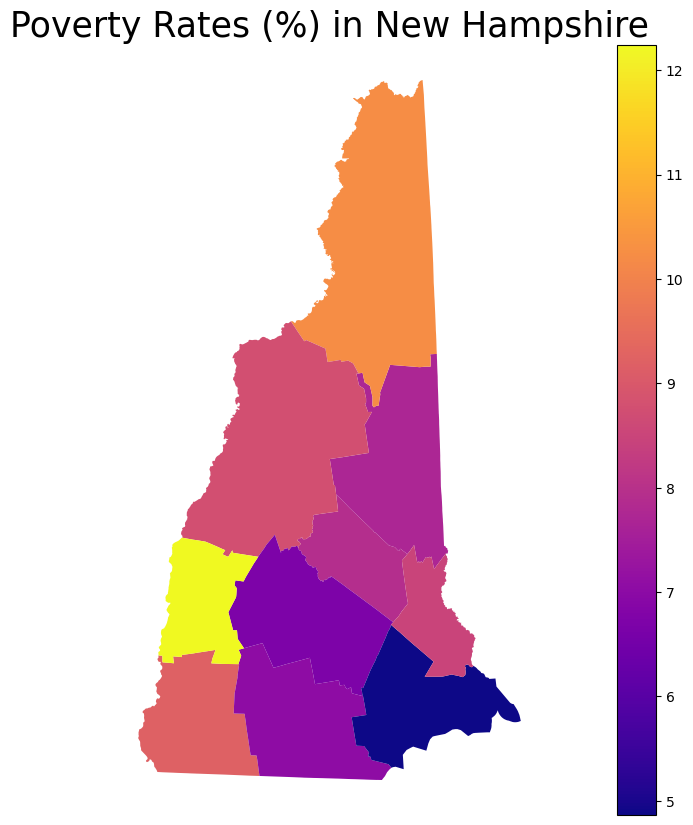

In [16]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
nh_population_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "plasma",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in New Hampshire', fontdict = {'fontsize': '25', 'fontweight' : '3'})
ax.set_axis_off()